In [130]:
import pandas as pd
from glob import glob
import os

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

checkpoints_dir = './checkpoints'
checkpoint_csv_files = glob(os.path.join(checkpoints_dir, '*-errorAnalysis.csv'))

print(checkpoint_csv_files)

['./checkpoints/openai-gpt-5-mini:fullPrompt:openrouter-errorAnalysis.csv']


In [131]:
df = pd.read_csv(checkpoint_csv_files[-1]) 



In [132]:
print(df.columns)
print(df.shape)

Index(['langgraph_thread_id', 'combined_name', 'model_name', 'provider',
       'trial_number', 'prompt_type', 'variant_type', 'nnz_flop_state',
       'top_p', 'temp', 'source_code', 'kernel_name', 'exec_args', 'grid_size',
       'block_size', 'total_num_threads', 'empirical_sp_flop_count',
       'empirical_dp_flop_count', 'raw_flop_counts', 'predicted_sp_flop_count',
       'predicted_dp_flop_count', 'predicted_sp_flop_count_explanation',
       'predicted_dp_flop_count_explanation', 'input_tokens', 'output_tokens',
       'total_cost', 'total_query_time', 'error', 'state_of_failure',
       'generic_model_name', 'has_nz_flops', 'percent_diff_sp',
       'percent_diff_dp', 'manualErrorClassification'],
      dtype='object')
(627, 34)


In [133]:
erroneous_cases = df[~df['manualErrorClassification'].isna()].copy()
print(erroneous_cases['manualErrorClassification'].shape)

(49,)


In [134]:
target_percent = 50
check_df = df[(df['percent_diff_sp'] > target_percent) | (df['percent_diff_dp'] > target_percent) | (df['percent_diff_sp'] < -target_percent) | (df['percent_diff_dp'] < -target_percent)]

assert erroneous_cases.shape[0] == check_df.shape[0]
assert erroneous_cases['langgraph_thread_id'].equals(check_df['langgraph_thread_id'])

In [135]:
# gather all the manualErrorClassification values and their counts
error_classes = set()

def scan_error_classes(errorStr):
    assert errorStr != None and errorStr != ''
    # split the errorStr by semicolon
    errors = errorStr.split(';')

    error_classes.update([e.strip() for e in errors if e.strip() != ''])

    return errorStr

erroneous_cases['manualErrorClassification'].apply(scan_error_classes)
print(f'Identified {len(error_classes)} unique error classes:')
for ec in error_classes:
    ec_str = ec
    # had to manually fix this one typo in the input file
    if 'uses half2 (FP16) precision' in ec_str:
        ec_str = 'uses half2 (FP16) precision -— reported as SP FLOPs'
        print('Fixed typo in error class')
    print(f' - {ec_str}')
    erroneous_cases[ec_str] = erroneous_cases['manualErrorClassification'].apply(lambda x: True if ec in x else False)


error_classes.remove('uses half2 (FP16) precision — reported as SP FLOP')

error_classes = sorted(list(error_classes))
print(erroneous_cases.columns)






Identified 16 unique error classes:
 - typedef float/double flipped
 - treated sign flip as 0 FLOP
Fixed typo in error class
 - uses half2 (FP16) precision -— reported as SP FLOPs
 - mistook exe args as a function input arg
 - missing header file with necessary code/values
 - has DD-warp divergence
 - incorrect global function input arg(s)
Fixed typo in error class
 - uses half2 (FP16) precision -— reported as SP FLOPs
 - has common sub-expressions
 - has special math function
 - has FP division
 - code comments made LLM assume X ops were taking place
 - typedef compiler arg -- not provided
 - incorrect __global__ function input arg
 - flop count explanation and reported value DIFFER
 - missing input arg needed from input file


KeyError: 'uses half2 (FP16) precision — reported as SP FLOP'

KeyError: "['uses half2 (FP16) precision -- reported as SP FLOPs'] not in index"

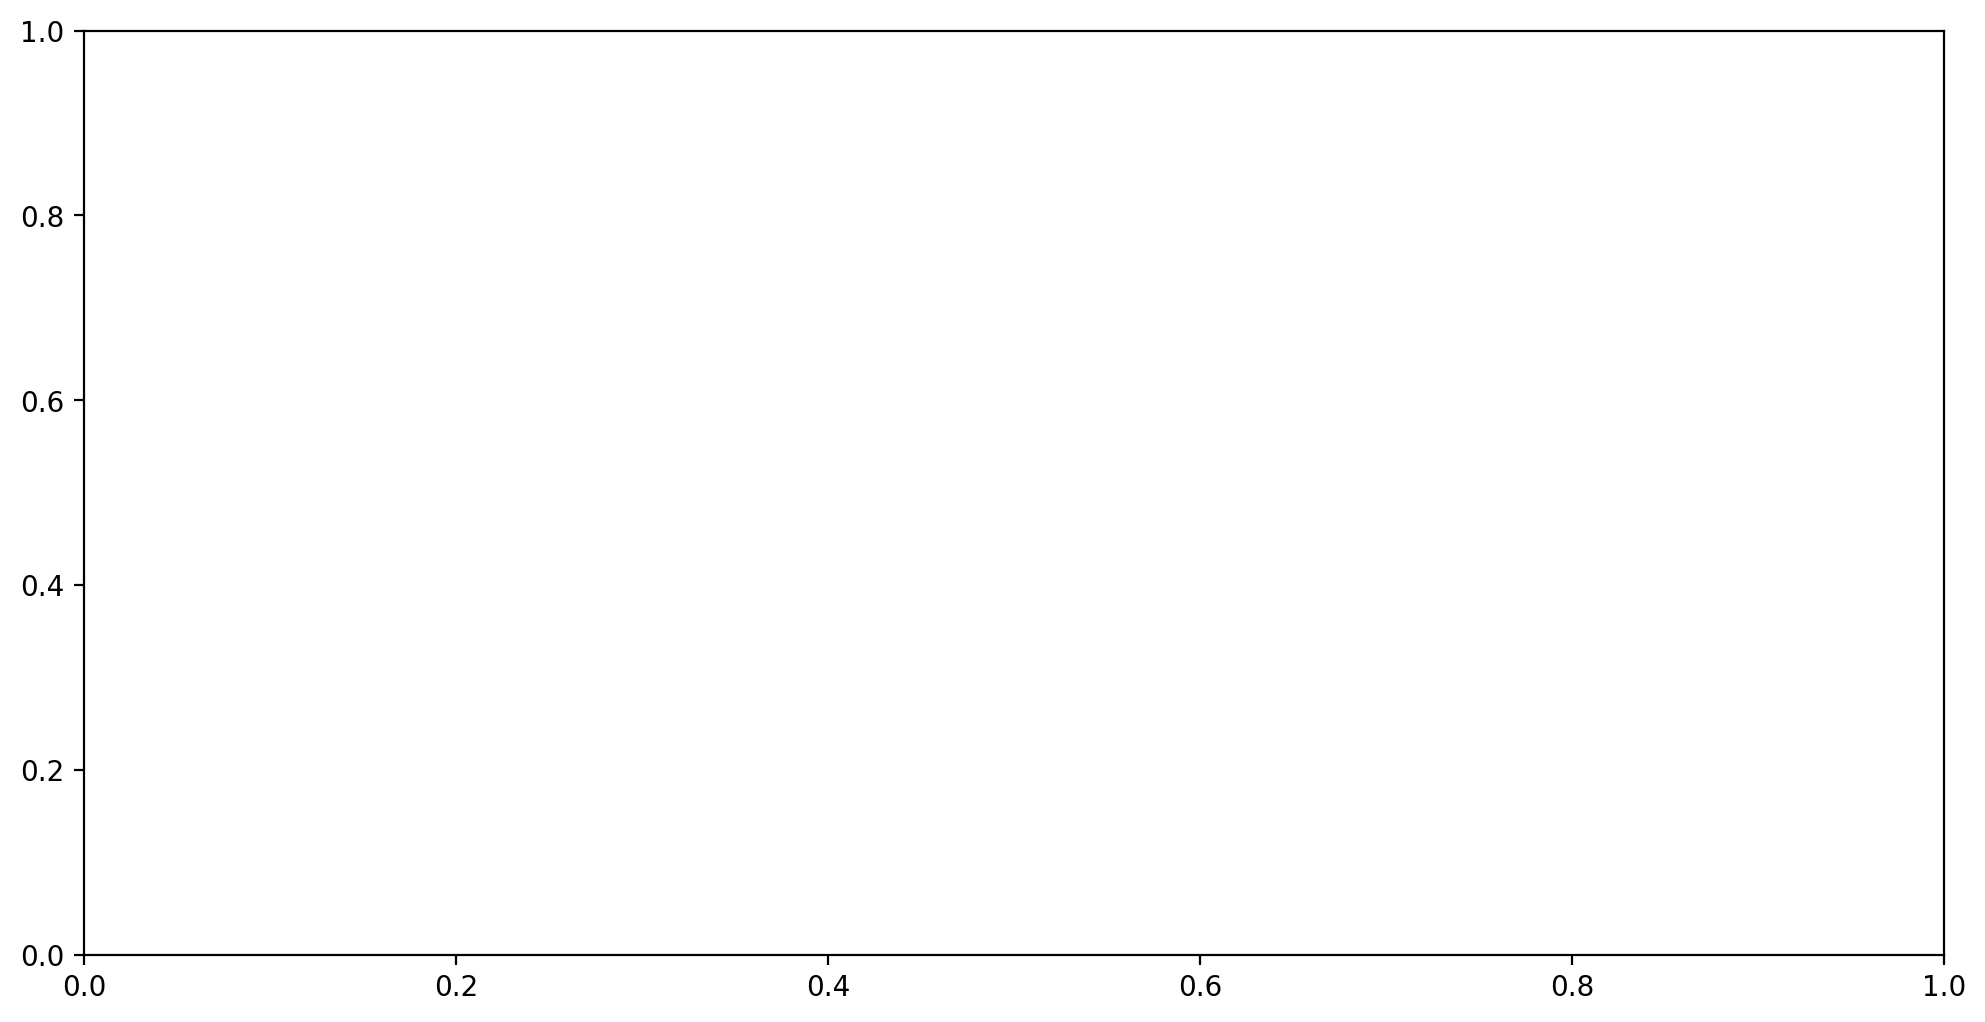

In [ ]:
# let's visualize the distribution of error classes

fig, ax = plt.subplots(1,1 , figsize=(12, 6), dpi=200)

# get column True counts
counts = erroneous_cases[error_classes].sum().sort_values(ascending=False)

print(counts)

sns.barplot(y=counts.index, x=counts.values, ax=ax)
